# Bitcoin Price Prediction

In this notebook we attempt to use deep learning to predict Bitcoin price based on past performance. Since price data are related to time, we will perform time series predictions with Recurrent Neural Network (RNN). 

## 1. Importing libraries and data

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"

In [3]:
df = pd.read_csv(csv_path, parse_dates=["Date"]).sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [4]:
df.shape

(3201, 7)

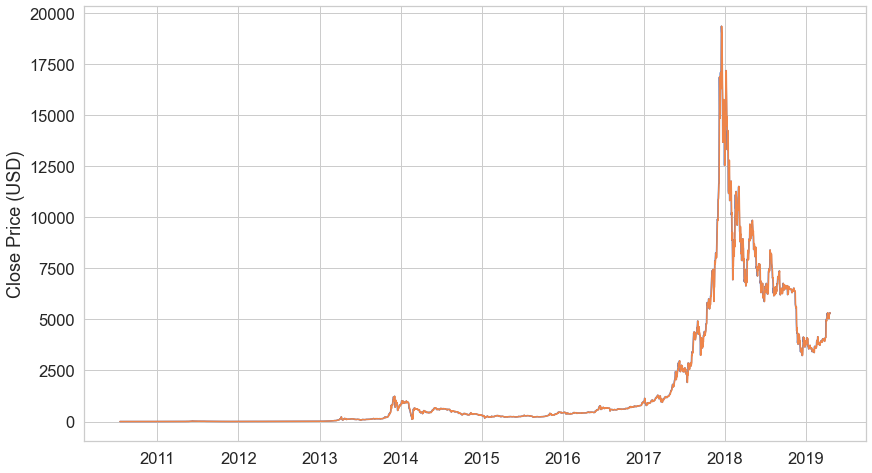

In [5]:
fig = plt.figure()
plt.plot(df["Date"], df["Close"])
plt.plot(df["Date"], df["Open"])
plt.ylabel("Close Price (USD)")
plt.show()

In [4]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

In [5]:
np.isnan(scaled_close).any()  ## Check for missing data

False

## 2. Preprocessing

In handling time series data, we generally split the data in a sliding window fashion. We will use a sequence length of 100, that means we will use data from day (x) to day (x + 100) to predict the price of day (101). So for time series, even a moderate dataset can get big quickly, when paired with a small sequence length.

In [7]:
seq_len = 100

def to_sequence(data, seq_length):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
        
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequence(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, seq_len, train_split=0.95)

We implement a RNN with a bidirectional LSTM layer, with dropout of 20% to avoid overfitting.

In [8]:
dropout = 0.2
window_size = seq_len - 1

model  =keras.models.Sequential([
    Bidirectional(LSTM(window_size, return_sequences=True),
                           input_shape=(window_size, X_train.shape[-1])),
    Dropout(rate=dropout),
    Bidirectional(LSTM(window_size*2, return_sequences=True)),
    Dropout(rate=dropout),
    Bidirectional(LSTM(window_size, return_sequences=False)),
    Dense(units=1, activation="linear")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 99, 198)           79992     
_________________________________________________________________
dropout (Dropout)            (None, 99, 198)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 99, 396)           628848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 396)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 198)               392832    
_________________________________________________________________
dense (Dense)                (None, 1)                 199       
Total params: 1,101,871
Trainable params: 1,101,871
Non-trainable params: 0
______________________________________________

In [15]:
model.compile(loss=keras.losses.mse,
             optimizer=keras.optimizers.Adam(lr=1e-5),
             metrics=["mse"])

We use a epoch of 50, but we also implemente `EarlyStopping` with patience of 10, which stops training when the monitored metric has stopped improving for 10 consecutive iterations. Then we use `ModelCheckpoint` to roll back to the best model and save it. 

In [16]:
es = keras.callbacks.EarlyStopping(patience=10)
mc = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs = 20, batch_size=64,
                   shuffle=False, validation_split=0.1, 
                   callbacks=[es, mc])

Epoch 1/20
42/42 [==============================] - 45s 957ms/step - loss: 1.9314e-04 - mse: 1.9314e-04 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2/20
42/42 [==============================] - 44s 1s/step - loss: 5.0887e-05 - mse: 5.0887e-05 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/20
42/42 [==============================] - 50s 1s/step - loss: 4.4489e-05 - mse: 4.4489e-05 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 4/20
42/42 [==============================] - 53s 1s/step - loss: 4.2506e-05 - mse: 4.2506e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/20
42/42 [==============================] - 53s 1s/step - loss: 4.0156e-05 - mse: 4.0156e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 6/20
42/42 [==============================] - 51s 1s/step - loss: 4.1115e-05 - mse: 4.1115e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/20
42/42 [==============================] - 54s 1s/step - loss: 4.2437e-05 - mse: 4.2437e-05 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/20
42/42 [=============

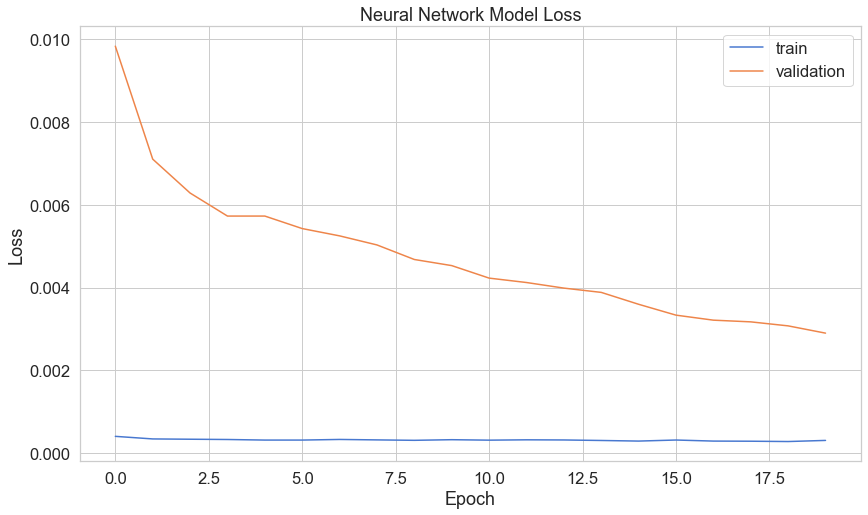

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Neural Network Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [18]:
best_model = keras.models.load_model("best_model.h5")

In [19]:
best_model.evaluate(X_test, y_test)

5/5 [==============================] - 2s 142ms/step - loss: 0.0013 - mse: 0.0013


[0.0012933699181303382, 0.0012933699181303382]

## Final Plot

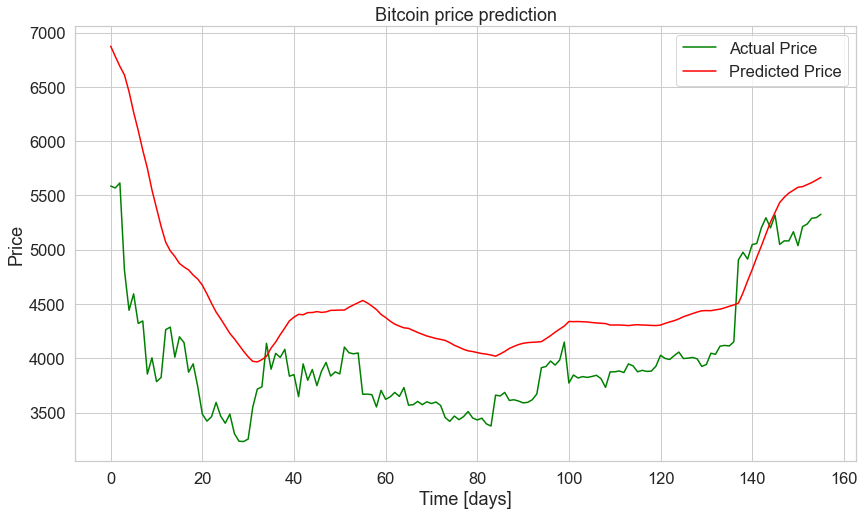

In [20]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

The general shape of predicted price resembles that of the actual price. On average, the predicted is around 500 USD over than the actual price. Furthermore, the predicted price appears much smoother than the actual price curve. This is normal for time series data, as neural network captures the general trend, rather than day-to-day variations. 